## encode traffic features

data source: Verkehrsmengen DTV 2019 (Umweltatlas)

features:

`tvi_x`: traffic volume index (tvi) for different radius, x = [25, 50, 75, 100, 200] normalized by radius

`prop_main_tvi_200`: proportion of heavy vehicles

`nearest_street_meter`: distance to nearest street

`nearest_intersect_meter`: distance to nearest intersection


In [30]:
# load data
import geopandas

sites = geopandas.read_file('data/monitoring_station/monitoring_station.shp')[['id', 'geometry']]
traffic = geopandas.read_file('data/traffic_volume_2019/traffic_volume_dtv_2019.shp')

# 1.2 check reference system - no adjustment needed 
print(f'Coordinate Reference System monitoring sites: {sites.crs}')
print(f'Coordinate Reference System traffic count data: {traffic.crs}')

Coordinate Reference System monitoring sites: EPSG:25833
Coordinate Reference System traffic count data: EPSG:25833


In [31]:
# extract tvi and
import matplotlib.pyplot as plt
import geopandas 



def calc_tvi(coordinate, radius, id, plot = False):
    
    # only consider roads within defined radius
    buffer  = geopandas.GeoDataFrame(geometry= [coordinate.buffer(radius)], crs=traffic.crs) # create polygon with buffer region around monitoring point
    in_buffer_one = geopandas.overlay(traffic, buffer, how='intersection') # intersect linestring (traffic road) with radius polygon to reduce to inside the radius 
    
    # calculate traffic volume index
    in_buffer_one['new_length'] = in_buffer_one['geometry'].length # calculate new length (within radius) per street
    in_buffer_one['main_emitter'] = in_buffer_one['lkw']   + in_buffer_one['linienbuss'] +  in_buffer_one['reisebusse'] # count main emitter to calc prop.
    in_buffer_one['volume_x_len'] = in_buffer_one['new_length'] * in_buffer_one['dtv']
    in_buffer_one['relative_street_len'] = in_buffer_one['new_length']/ in_buffer_one['new_length'].sum()
    tvi = in_buffer_one['volume_x_len'].sum()/(10000 * radius) # normalized by range
    prop_main_emitter = (in_buffer_one['main_emitter']/ in_buffer_one['dtv'] * in_buffer_one['relative_street_len']).sum()
    
    if plot == True: 
        in_buffer_one['geometry'] = in_buffer_one.buffer(radius/40)
        ax = buffer.plot(alpha=0.1, edgecolor='black')
        in_buffer_one.plot(ax=ax, column='dtv', cmap='Reds', legend=True) #, vmin= 0, vmax = 10,)
        ax.set_title(f'{id} with radius of {radius}')
        plt.show() 
    
    return tvi, prop_main_emitter

for radius in [25,50,75,100,200]:
    sites[f'tvi_{radius}'] = sites.apply(lambda row: calc_tvi(coordinate=row['geometry'], radius=radius, id=row['id'], plot = False)[0], axis=1)

sites[f'prop_main_tvi_{200}'] = sites.apply(lambda row: calc_tvi(coordinate=row['geometry'], radius=200, id=row['id'], plot = False)[1], axis=1)
sites.head(4)

,id,geometry,tvi_25,tvi_50,tvi_75,tvi_100,tvi_200,prop_main_tvi_200
0,MC 042,POINT (393459.02 5816635.25),0.000000,0.000000,0.000000,0.000000,0.989238,0.113111
1,MC 124,POINT (390406.146 5810991.699),7.356094,7.878518,7.976514,8.777857,10.390357,0.080445
2,MC 143,POINT (394135.247 5814178.61),2.272461,4.782303,5.207626,5.316963,5.356686,0.039749
3,MC 171,POINT (392699.56 5819341.461),0.000000,0.000000,0.377908,2.104888,6.336192,0.032525


###

In [32]:
# calculate distance between monitoring site and nearest street + intersection 
from shapely import geometry 
import pandas as pd

# 1. extract intersection points (as beginning & end of each street linestring)
frist_coord = traffic['geometry'].apply(lambda x: geometry.Point(list(x.coords)[0]))
last_coord = traffic['geometry'].apply(lambda x: geometry.Point(list(x.coords)[-1]))
intersection_points = pd.concat([frist_coord, last_coord])

# 2. calculate nearest point / street intersection
def distance_nearest_intersection(point):
    return intersection_points.apply(lambda x: point.distance(x)).min()

# 3. calculate distance between monitoring site and nearest street
def distance_nearest_street(point):
    return traffic['geometry'].apply(lambda x: point.distance(x)).min()

# 4. Apply to all sites
sites['nearest_intersect_meter'] = sites['geometry'].apply(lambda x: distance_nearest_intersection(x))
sites['nearest_street_meter'] = sites['geometry'].apply(lambda x: distance_nearest_street(x))

### encode population density
data source: fis broker

features:


`pop_x`: number of registered habitants in range x, x = [200, 500]

In [33]:
# read data
import geopandas as gpd
popu = gpd.read_file('data/population/population.shp')[['ew2022', 'geometry']]
popu['original_area'] = popu['geometry'].area #add area site to 

# 1.2 check reference system - no adjustment needed 
print(f'Coordinate Reference System green volume: {popu.crs}')


# find total population per radius
def get_popu_per_radius(coordinate, radius):
    buffer = gpd.GeoDataFrame(geometry= [coordinate.buffer(radius)], crs= popu.crs) # build radius around sensing site
    in_buffer = gpd.overlay(popu, buffer, how='intersection') # intersect and keep only those polygons inside radius area
    in_buffer['area'] = in_buffer['geometry'].area # calculate area size of new polygons inside radius 
    in_buffer['weighted_pop'] = round(in_buffer['area']/ in_buffer['original_area'] *in_buffer['ew2022'])
    
    return in_buffer['weighted_pop'].sum()

sites['pop_200'] = sites['geometry'].apply(lambda x: get_popu_per_radius(coordinate = x, radius = 200) )
sites['pop_500'] = sites['geometry'].apply(lambda x: get_popu_per_radius(coordinate = x, radius = 500) )

#sites.to_file('data/population/buffer_radius/population_per_site.shp')
sites.head(5)

Coordinate Reference System green volume: EPSG:25833


,id,geometry,tvi_25,tvi_50,tvi_75,tvi_100,tvi_200,prop_main_tvi_200,nearest_intersect_meter,nearest_street_meter,pop_200,pop_500
0,MC 042,POINT (393459.02 5816635.25),0.000000,0.000000,0.000000,0.000000,0.989238,0.113111,155.007390,154.096745,2984.0,19158.0
1,MC 124,POINT (390406.146 5810991.699),7.356094,7.878518,7.976514,8.777857,10.390357,0.080445,74.625936,10.254152,702.0,6332.0
2,MC 143,POINT (394135.247 5814178.61),2.272461,4.782303,5.207626,5.316963,5.356686,0.039749,33.830426,7.490619,1995.0,12259.0
3,MC 171,POINT (392699.56 5819341.461),0.000000,0.000000,0.377908,2.104888,6.336192,0.032525,76.895299,74.313229,787.0,7917.0
4,MC 174,POINT (396182.715 5819313.198),6.093263,7.654616,8.028282,8.162586,8.543938,0.028151,36.321913,16.057956,3698.0,21292.0


C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_b

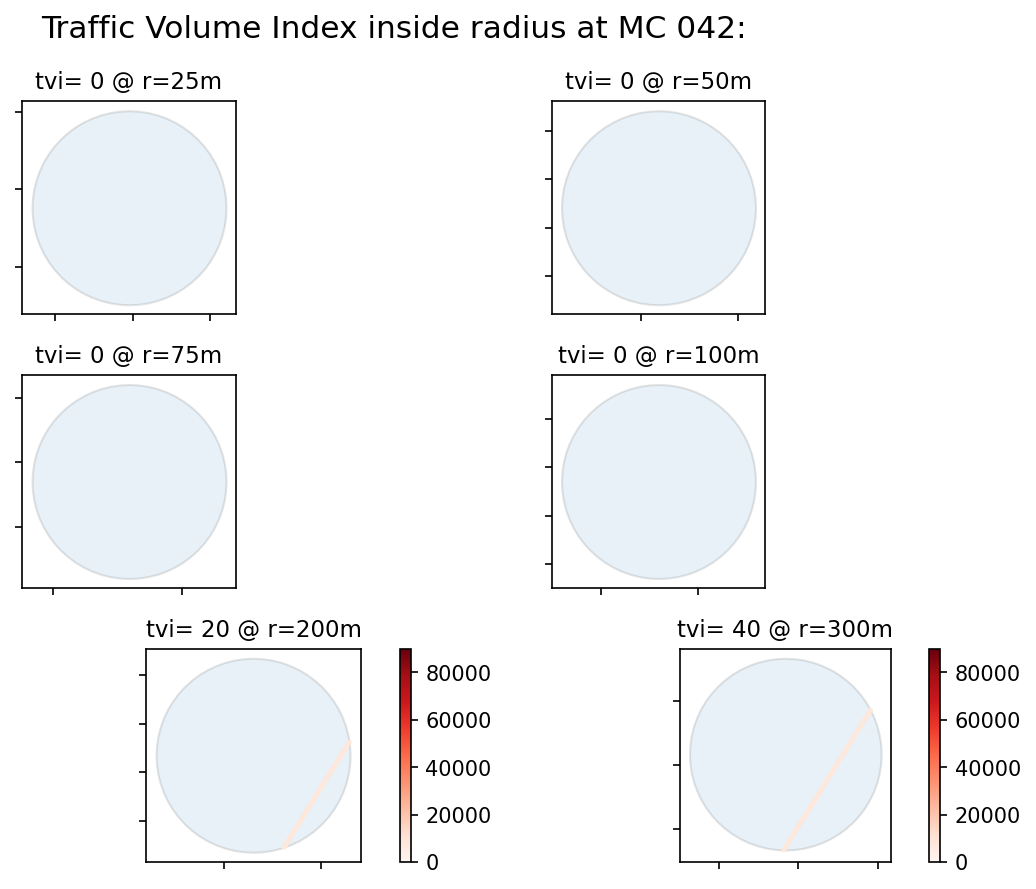

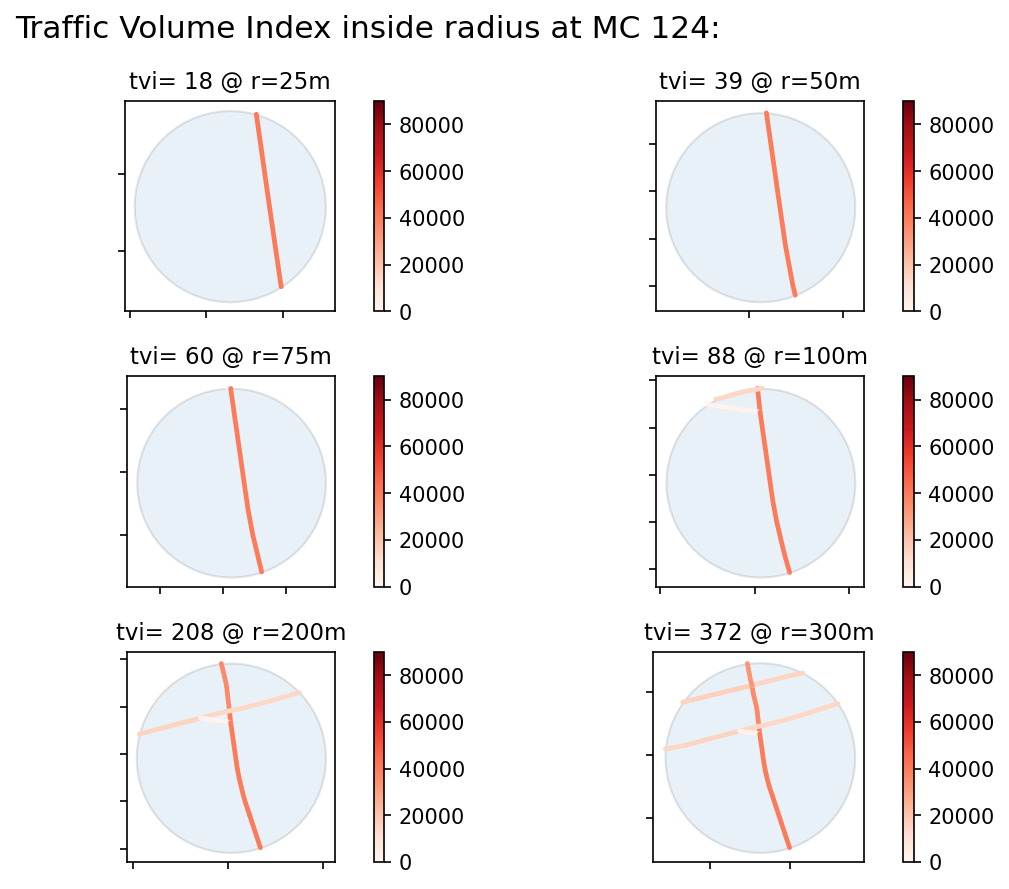

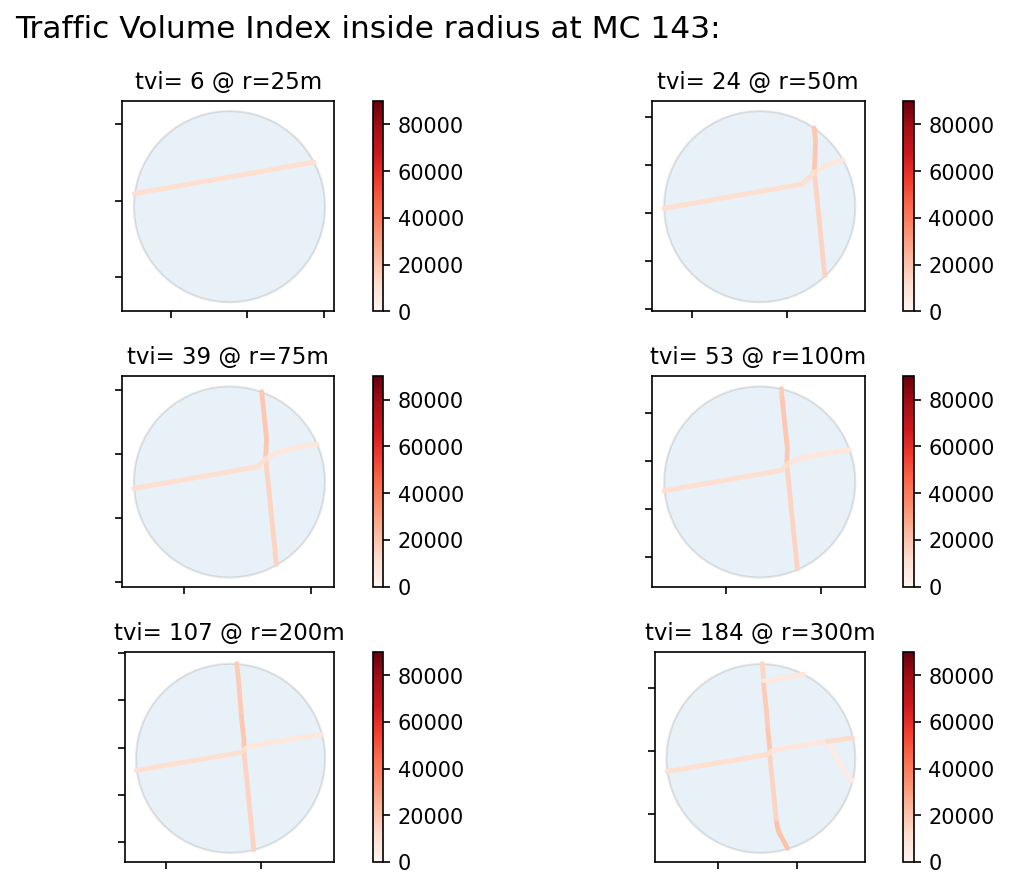

C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)


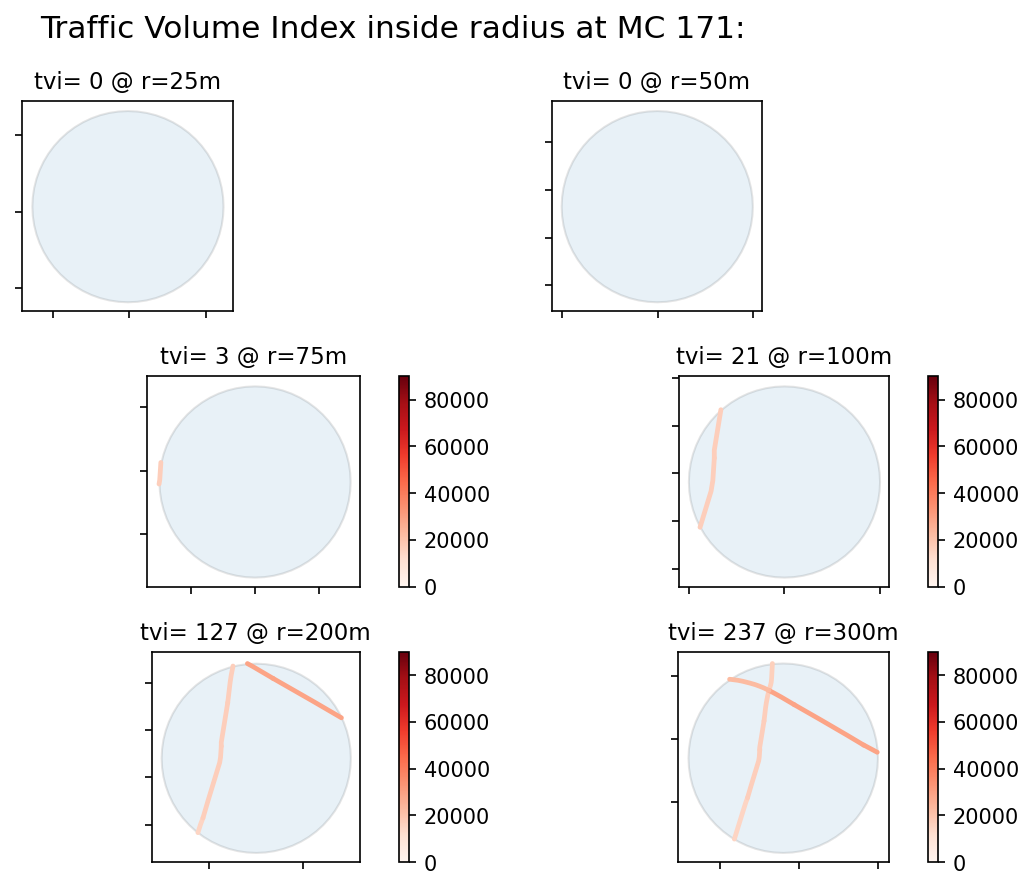

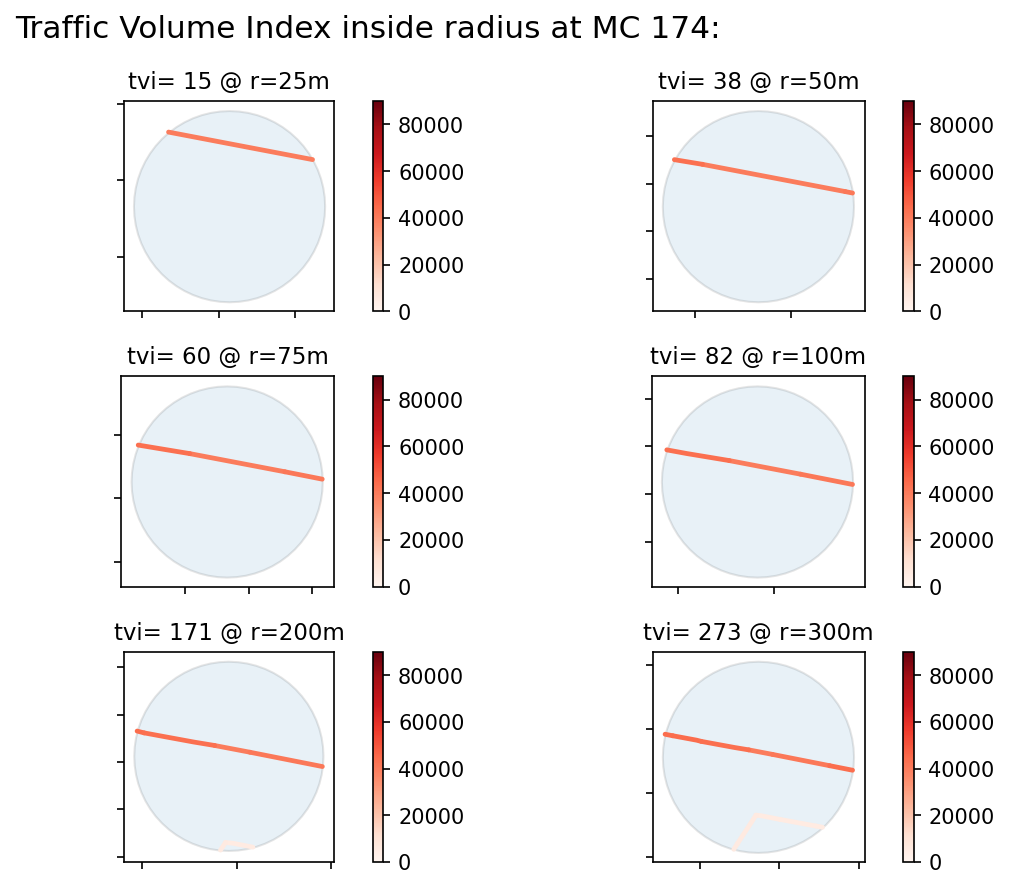

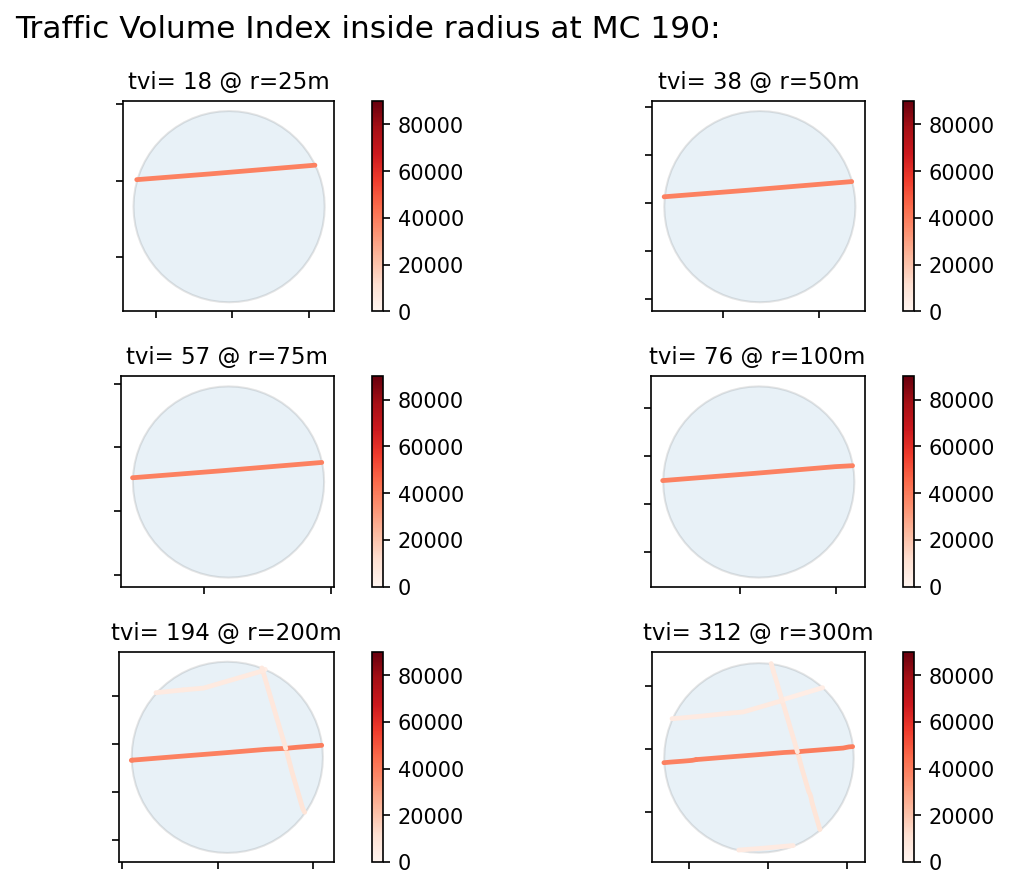

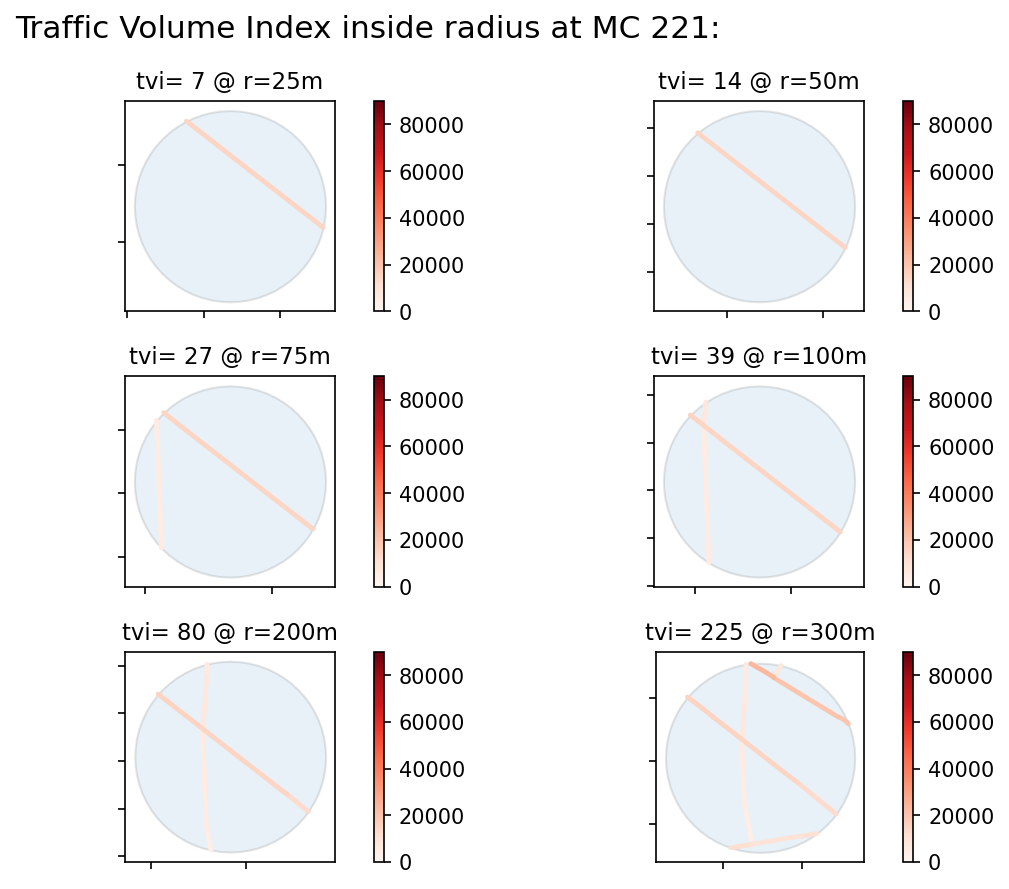

C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_b

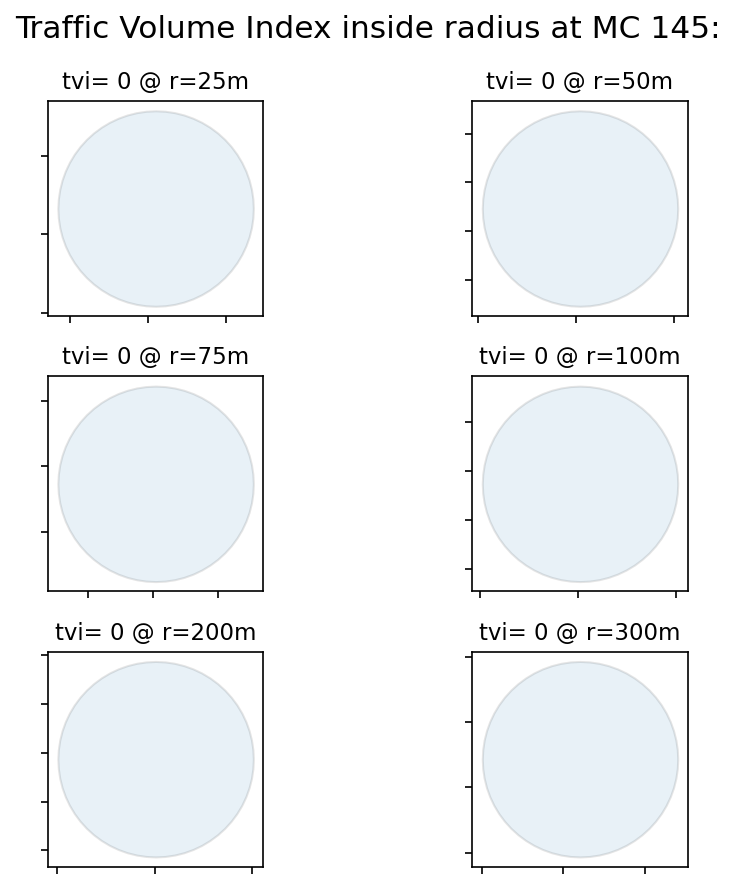

C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)


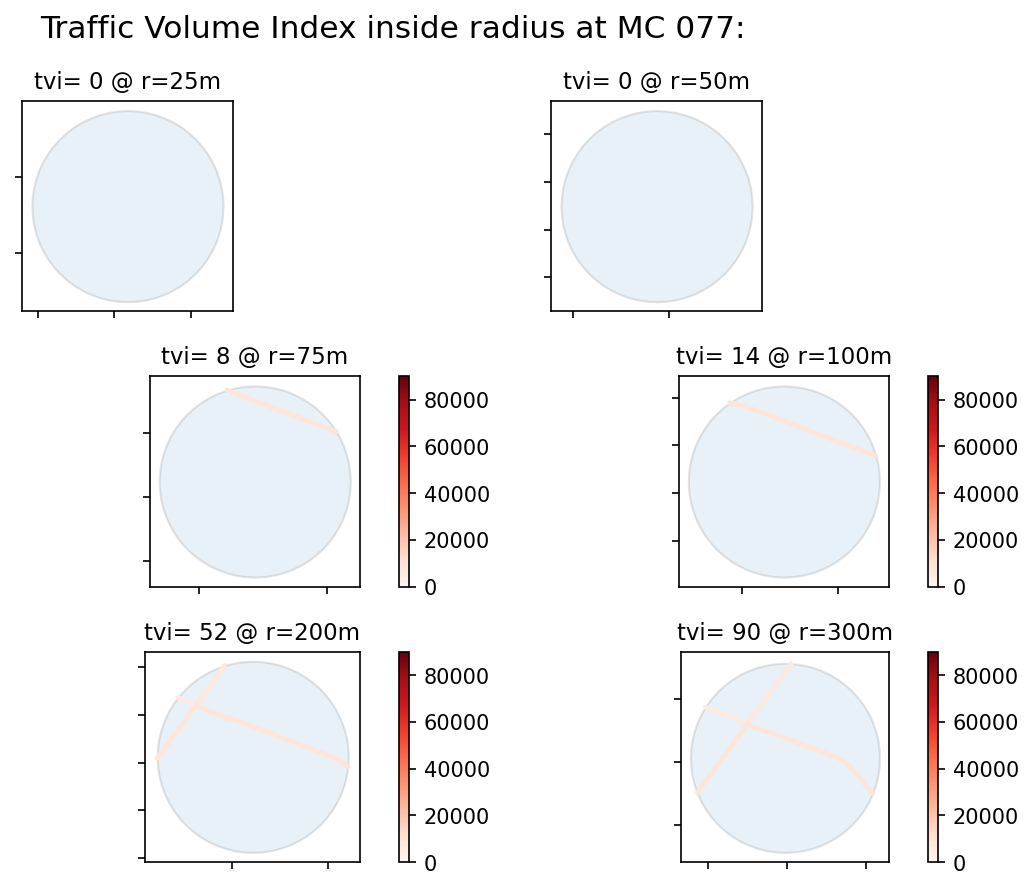

C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)


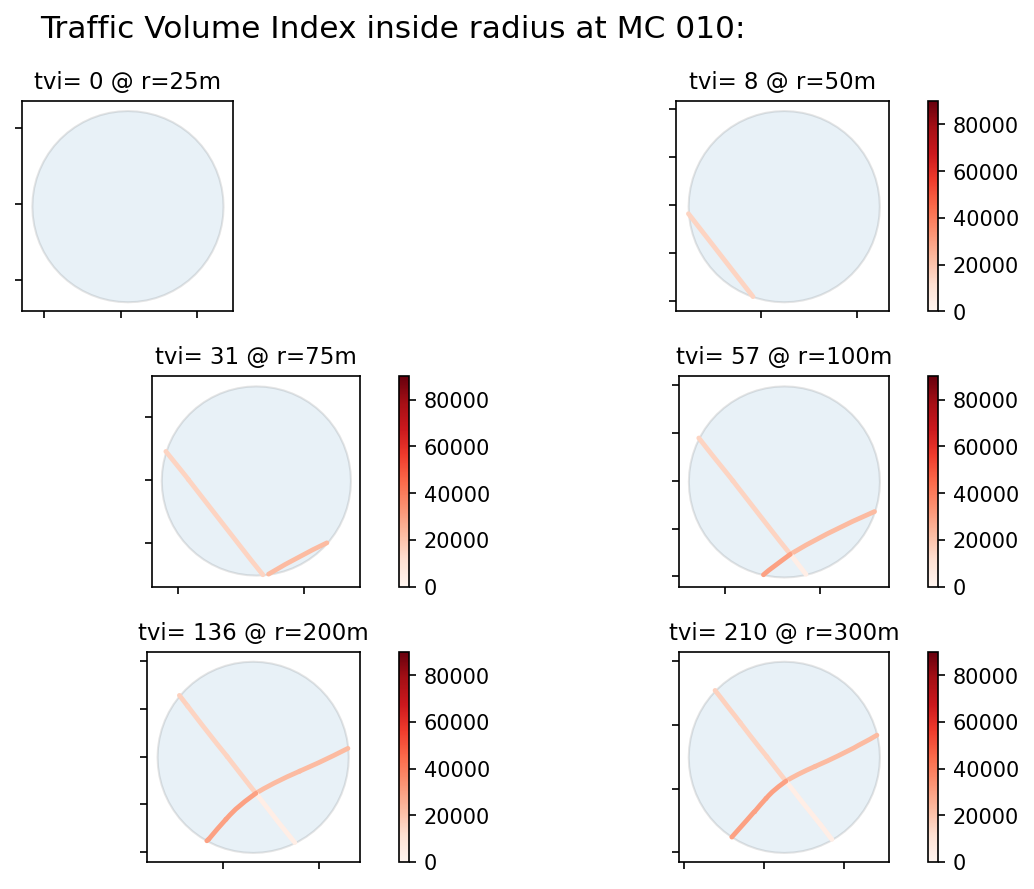

C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_b

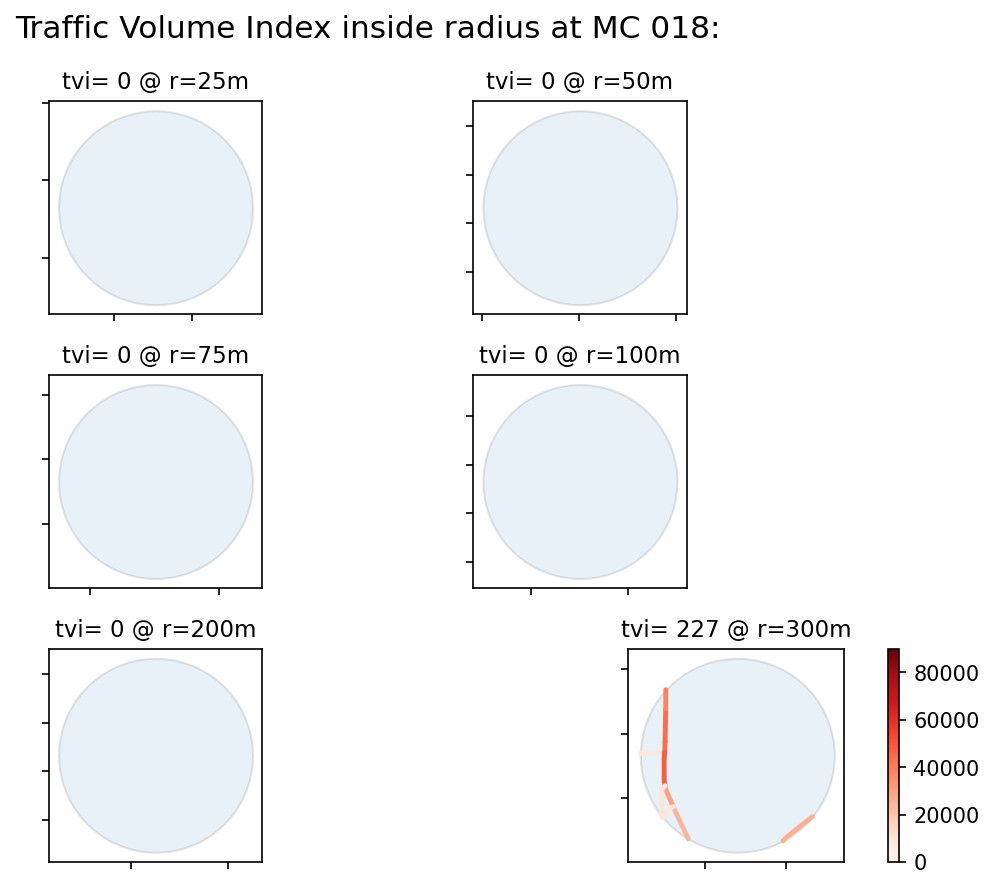

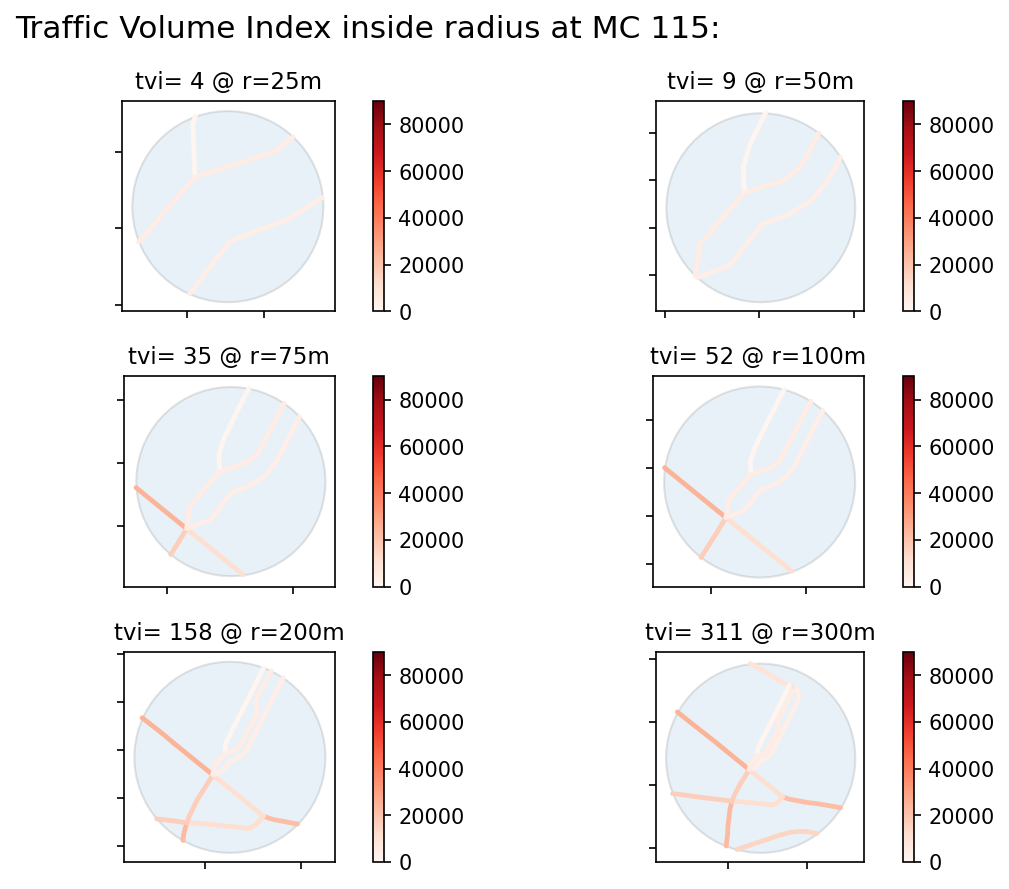

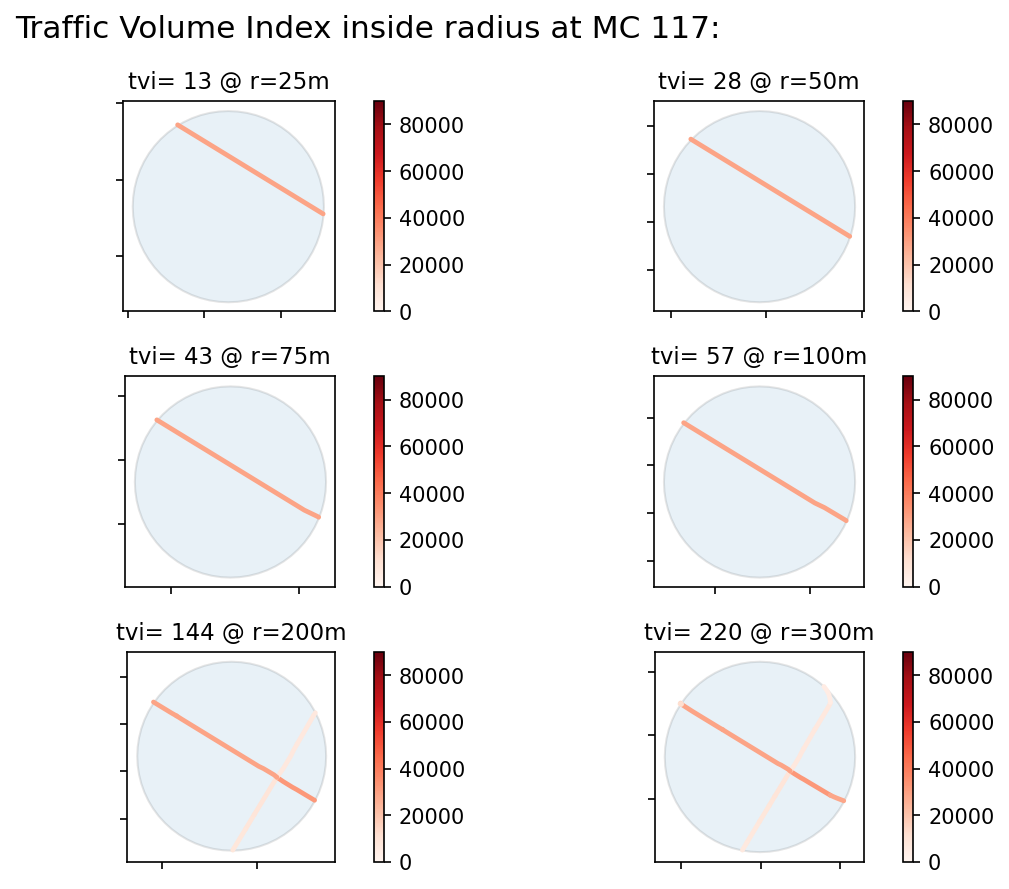

C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_b

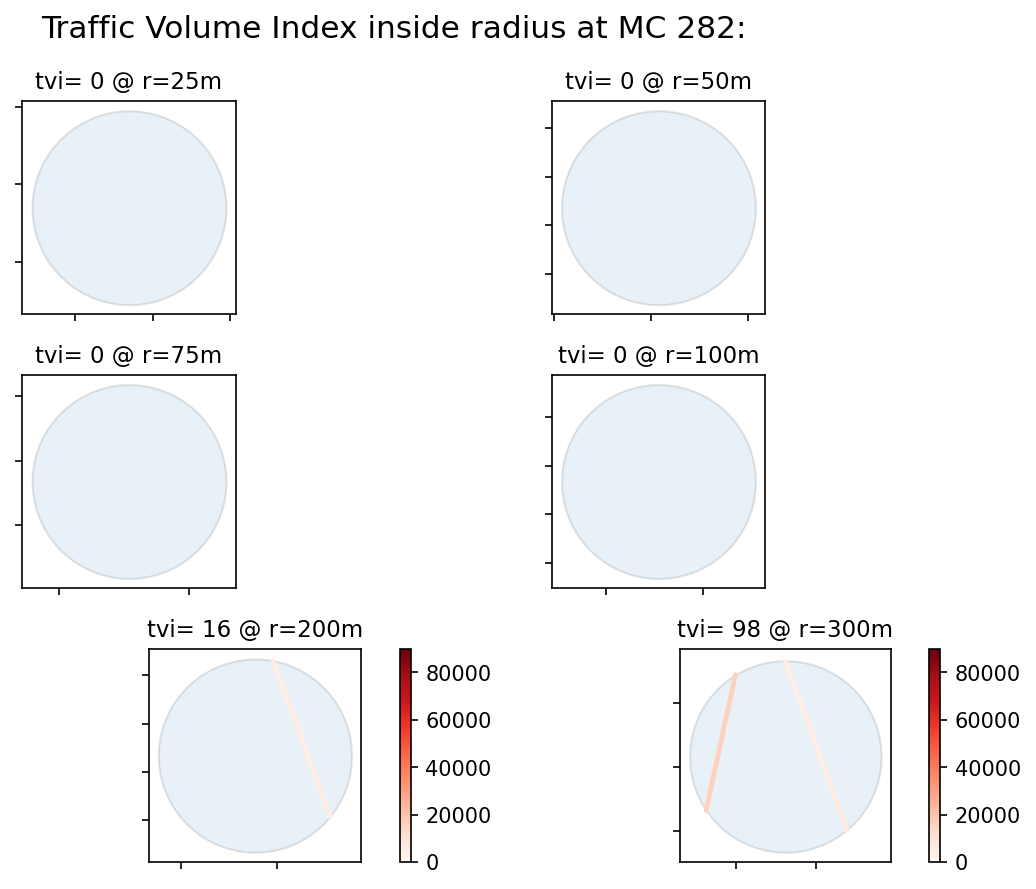

C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_b

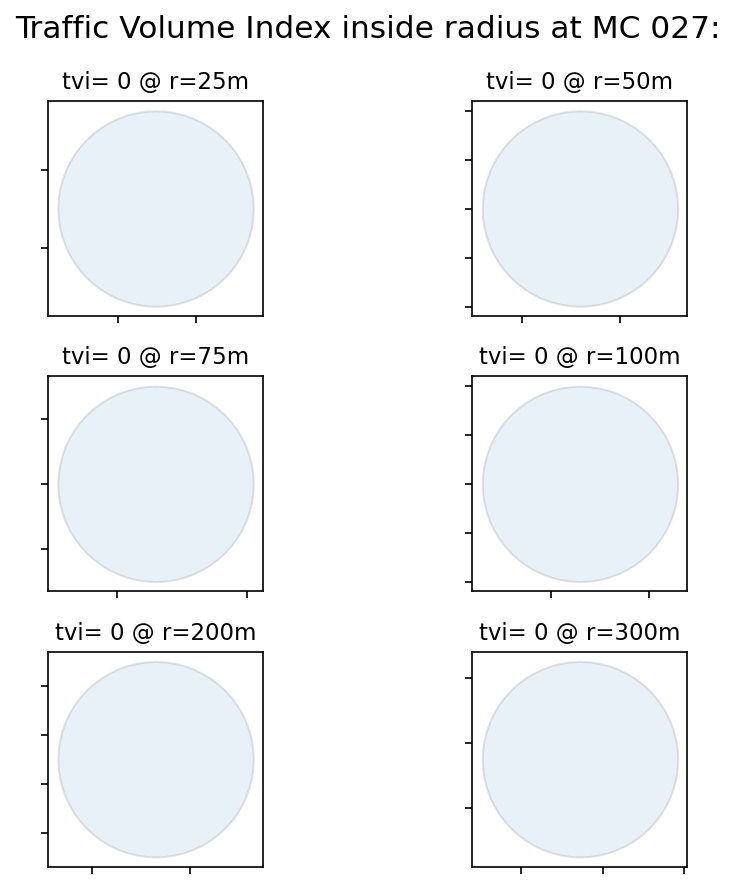

C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
C:\Users\Richard\AppData\Local\Temp\ipykernel_17048\681236920.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = in_b

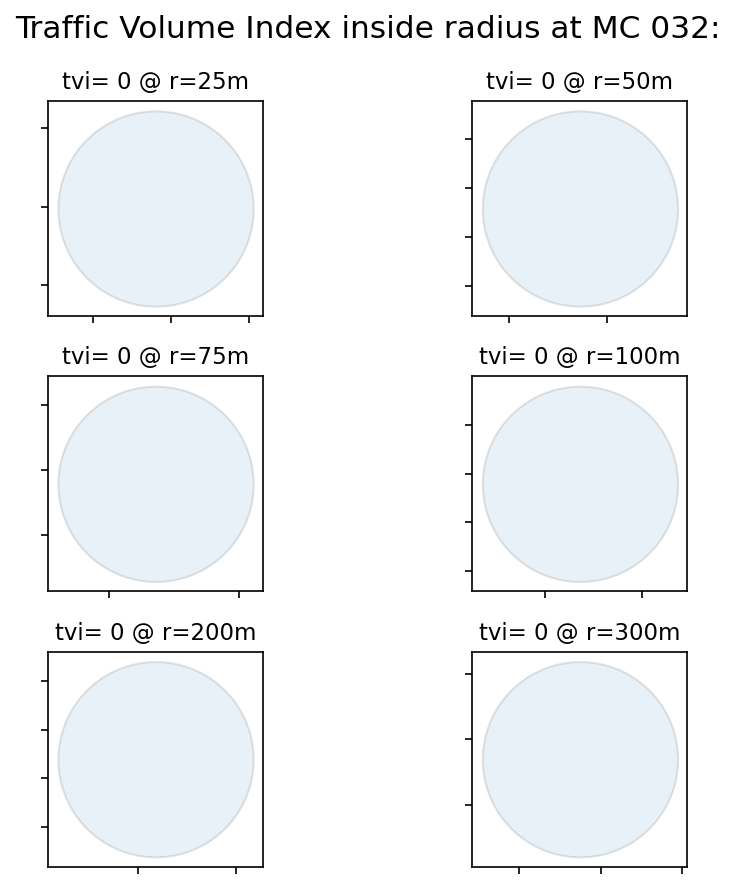

In [34]:
# plot differing traffic volume index at sites and changing radius  
import geopandas 
import matplotlib.pyplot as plt 

for n in range(len(sites['id'])):
    name = sites['id'][n]
    
    radius = [25,50,75,100,200,300]
    coordinate = sites['geometry'][n]


    fig, axs = plt.subplots((len(radius)//2), 2, figsize=(9, 6), dpi=150)
    fig.suptitle(f'Traffic Volume Index inside radius at {name}:', fontsize =15)


    for n in range(len(radius)):

        buffer  = geopandas.GeoDataFrame(geometry= [coordinate.buffer(radius[n])], crs=traffic.crs) # create polygon with buffer region around monitoring point
        in_buffer_one = geopandas.overlay(traffic, buffer, how='intersection') # intersect linestring (traffic road) with radius polygon to reduce to inside the radius 
        # calculate traffic volume index
        in_buffer_one['new_length'] = in_buffer_one['geometry'].length # calculate new length (within radius) of street
        in_buffer_one['volume_x_len'] = in_buffer_one['new_length'] * in_buffer_one['dtv']
        tvi = round(in_buffer_one['volume_x_len'].sum()/ 100000)
        street_len = in_buffer_one['new_length'].sum()
    
        # plot different VVI over radius
        row = n//2
        column = 0 if (n+1)%2 != 0 else 1

        in_buffer_one['geometry'] = in_buffer_one.buffer(radius[n]/40)

        ax = buffer.plot(ax = axs[row, column], alpha=0.1, edgecolor='black')
        ax = in_buffer_one.plot(ax=axs[row, column], column='dtv', cmap='Reds', legend=True, vmin= 0, vmax = 90000,)
        
        axs[row, column].set_title(f'tvi= {tvi} @ r={radius[n]}m', {'fontsize':11})
        axs[row, column].set_xticklabels([])
        axs[row, column].set_yticklabels([])
        #in_buffer_one.plot(ax=ax, column='dtv', cmap='Reds', legend=True) #, vmin= 0, vmax = 10,)
        plt.tight_layout()
           
    plt.savefig(f"output/emitting_source/TVI_{name}.png", dpi = 450)
    plt.show()

        

In [ ]:
sites = pd.DataFrame(sites.drop(['geometry'], axis = 1))
sites.to_csv('output/emitting_source/emitting_source.csv')
sites.head(5)